In [8]:
import numpy as np
import torch

NR_UNIQUE_INPUTS = 10
GRID_SIZE = 4
VARIANCE = 0.1
NR_CHANNELS = 3
NR_INPUTS_PER_GROUND_TRUTH = 10

def generate_checkerboard_samples(N, size):
    # Initialize a tensor to hold the N samples of checkerboard patterns
    samples = torch.zeros((N, size, size, 3))  # 3 for RGB channels

    for i in range(N):
        # Generate random colors for the checkerboard
        color1 = torch.rand(3, dtype=torch.float32)  # Color for one set of squares
        color2 = torch.rand(3, dtype=torch.float32)  # Color for the other set of squares

        for x in range(size):
            for y in range(size):
                if (x + y) % 2 == 0:
                    samples[i, x, y] = color1
                else:
                    samples[i, x, y] = color2

    return samples


samples = generate_checkerboard_samples(2, GRID_SIZE)
print(samples[1])

tensor([[[0.3472, 0.8843, 0.1944],
         [0.5384, 0.6059, 0.1500],
         [0.3472, 0.8843, 0.1944],
         [0.5384, 0.6059, 0.1500]],

        [[0.5384, 0.6059, 0.1500],
         [0.3472, 0.8843, 0.1944],
         [0.5384, 0.6059, 0.1500],
         [0.3472, 0.8843, 0.1944]],

        [[0.3472, 0.8843, 0.1944],
         [0.5384, 0.6059, 0.1500],
         [0.3472, 0.8843, 0.1944],
         [0.5384, 0.6059, 0.1500]],

        [[0.5384, 0.6059, 0.1500],
         [0.3472, 0.8843, 0.1944],
         [0.5384, 0.6059, 0.1500],
         [0.3472, 0.8843, 0.1944]]])


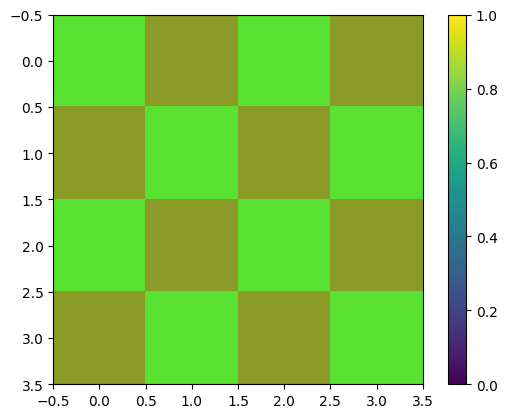

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def visualize(matrix : np.ndarray, title : str = ""):
    plt.imshow(matrix, interpolation='none', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.show()

visualize(samples[1])

In [10]:
def add_noise(input: np.ndarray, sigma : float) -> np.ndarray:

    noisy_input = input + torch.randn(input.shape) * sigma
    noisy_input = np.clip(noisy_input, 0, 1)

    return noisy_input

In [11]:
ground_truth = generate_checkerboard_samples(NR_UNIQUE_INPUTS, GRID_SIZE)

torch.Size([10000, 4, 4, 3]) torch.Size([10000, 4, 4, 3])


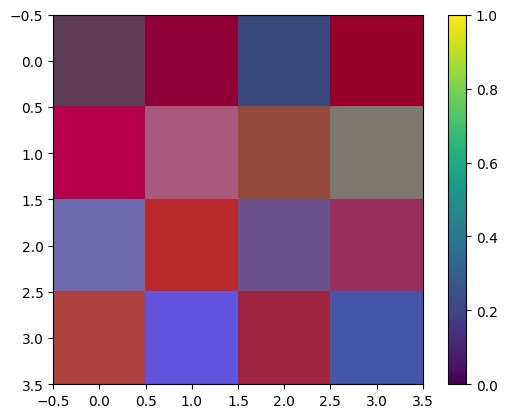

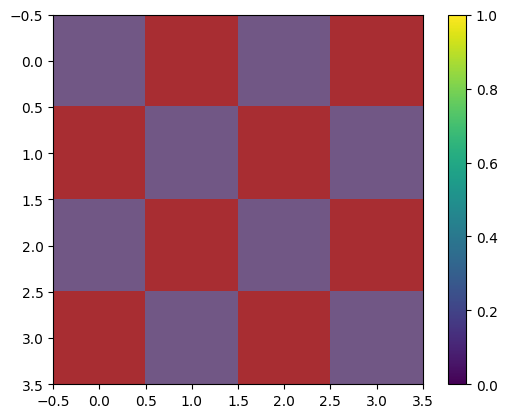

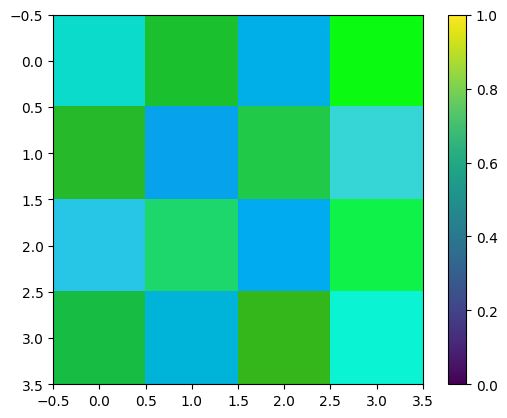

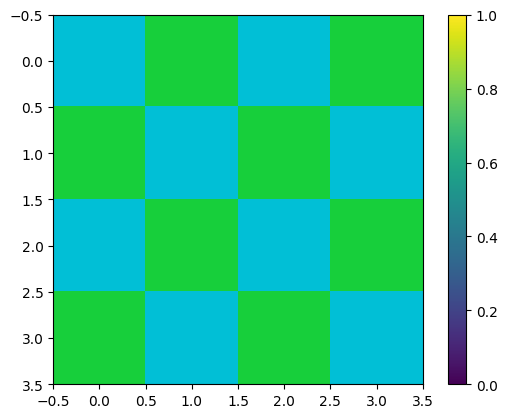

torch.Size([10000, 48])


In [12]:
def generate_dataset(ground_truth):
    grid_size = ground_truth.shape[1]

    inputs = torch.empty(len(ground_truth) * NR_INPUTS_PER_GROUND_TRUTH, grid_size, grid_size, 3)
    outputs = torch.empty(len(ground_truth) * NR_INPUTS_PER_GROUND_TRUTH, grid_size, grid_size, 3)

    for i, no_noise_image in enumerate(ground_truth):
        for j in range(NR_INPUTS_PER_GROUND_TRUTH):
            inputs[i*NR_INPUTS_PER_GROUND_TRUTH + j] = add_noise(no_noise_image, VARIANCE)
            outputs[i*NR_INPUTS_PER_GROUND_TRUTH + j] = no_noise_image # this may waste memory. Investigate if memory becomes an issue
    
    return inputs, outputs
    
dataset_inputs, dataset_outputs = generate_dataset(ground_truth)
print(dataset_inputs.shape, dataset_inputs.shape)

nr_inputs = len(dataset_inputs)

sampled_numbers = np.random.choice(nr_inputs, size=min(2, len(dataset_inputs)), replace=False)
# print(sampled_numbers)
for i in sampled_numbers:
    visualize(dataset_inputs[i])
    visualize(dataset_outputs[i])

straightened_inputs = dataset_inputs.view(nr_inputs, -1)
straightened_outputs = dataset_outputs.view(nr_inputs, -1)

print(straightened_inputs.shape)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        # self.fc1 = nn.Linear(in_features=GRID_SIZE*GRID_SIZE*NR_CHANNELS, out_features=3*NR_CHANNELS)
        # self.fc2 = nn.Linear(in_features=3*NR_CHANNELS, out_features=GRID_SIZE*GRID_SIZE*NR_CHANNELS)
        self.fc1 = nn.Linear(in_features=GRID_SIZE*GRID_SIZE*NR_CHANNELS, out_features=GRID_SIZE*GRID_SIZE*NR_CHANNELS)
        self.final_activation_fn = nn.Sigmoid()
        # self.ReLU = nn.ReLU()

    def forward(self, x):
        output = self.fc1(x)
        # output = self.fc2(output)
        # output = self.ReLU(output)
        output = self.final_activation_fn(output)

        return output


model = DiffusionModel()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

num_epochs = 10

cost_arr = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_samples, ground_truth_samples in zip(straightened_inputs, straightened_outputs):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_samples)

        loss = criterion(outputs, ground_truth_samples)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if epoch % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], cost={running_loss}')
    cost_arr.append(loss.item())

print('Training finished.')

KeyboardInterrupt: 

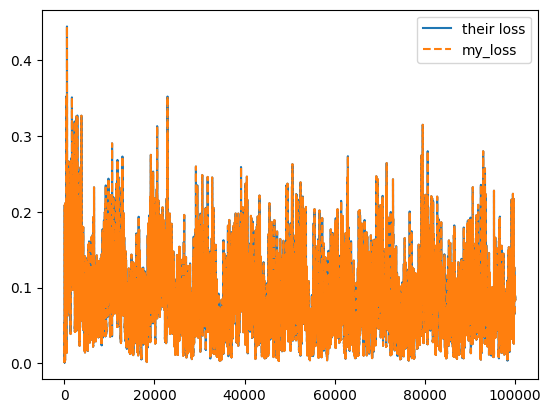

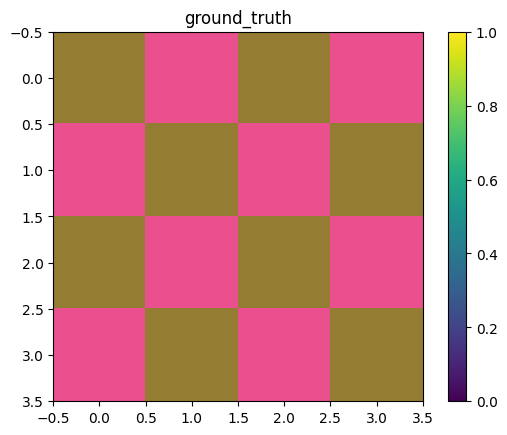

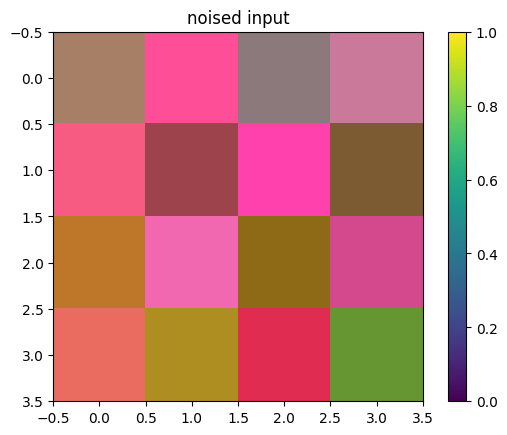

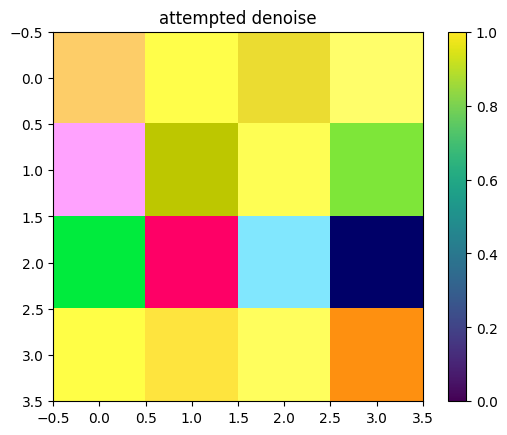

In [15]:
x = ((1.0*my_loss[0])/loss_arr[0])**(-1)
plt.plot(loss_arr, label='their loss')
plt.plot([cur*x for cur in my_loss], label='my_loss', linestyle='--')
plt.legend()
plt.show()


def visualize_model_perf(idx):
    input = straightened_inputs[idx]

    output = model(input)

    picture_output = output.view(GRID_SIZE, GRID_SIZE, NR_CHANNELS)
    visualize(dataset_outputs[idx], "ground_truth")
    visualize(input.view(GRID_SIZE, GRID_SIZE, NR_CHANNELS), "noised input")
    visualize(picture_output.detach(), "attempted denoise")

visualize_model_perf(0)